In [1]:
# Cargamos las librerías
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/quejas.csv')

In [3]:
# Creación de la variable objetivo
df['renuncia'] = df.apply(lambda row: 1 if row['probabilidad'] > 3 else 0, axis=1)

# Eliminamos columnas no relevantes
df = df.drop(['id_conductor', 'nombre', 'celular', 'probabilidad'], axis=1)

# Codificamos variables categóricas
label_encoder = LabelEncoder()
df['categoria'] = label_encoder.fit_transform(df['categoria'])

# Vectorización del texto libre en 'queja'
tfidf_vectorizer = TfidfVectorizer()
queja_tfidf = tfidf_vectorizer.fit_transform(df['queja']).toarray()

# Añadimos las características de 'queja' al dataframe
queja_df = pd.DataFrame(queja_tfidf, columns=[f'queja_{i}' for i in range(queja_tfidf.shape[1])])
df = pd.concat([df.drop('queja', axis=1), queja_df], axis=1)

# Variables predictoras y variable objetivo
X = df.drop('renuncia', axis=1)
y = df['renuncia']

In [4]:
smote = SMOTE(sampling_strategy={0: 1500, 1: 1500})

In [5]:
X_over, y_over = smote.fit_resample(X, y)

In [6]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Modelo XGBoost
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='mlogloss',
                          learning_rate = 0.05, max_depth = 5, min_child_weight = 1, scale_pos_weight = 1)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [7]:
# Predicciones
y_pred = model.predict(X_test)

# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.83
Confusion Matrix:
[[238  60]
 [ 42 260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       298
           1       0.81      0.86      0.84       302

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



In [8]:
df_val = pd.read_csv('../data/quejas_val.csv')

In [9]:
df_val['renuncia'] = df_val.apply(lambda row: 1 if row['probabilidad'] > 3 else 0, axis=1)

# Eliminamos columnas no relevantes
df_val = df_val.drop(['id_conductor', 'nombre', 'celular', 'probabilidad'], axis=1)

# Codificamos variables categóricas
df_val['categoria'] = label_encoder.transform(df_val['categoria'])

# Vectorización del texto libre en 'queja'
queja_val_tfidf = tfidf_vectorizer.transform(df_val['queja']).toarray()

# Añadimos las características de 'queja' al dataframe
queja_val_df = pd.DataFrame(queja_val_tfidf, columns=[f'queja_{i}' for i in range(queja_val_tfidf.shape[1])])
df_val = pd.concat([df_val.drop('queja', axis=1), queja_val_df], axis=1)

# Variables predictoras y variable objetivo
X_val = df_val.drop('renuncia', axis=1)
y_val = df_val['renuncia']

In [10]:
y_val_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Accuracy: 0.75
Confusion Matrix:
[[ 2  2]
 [ 3 13]]


In [11]:
import matplotlib.pyplot as plt

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
roc_auc = auc(fpr, tpr)

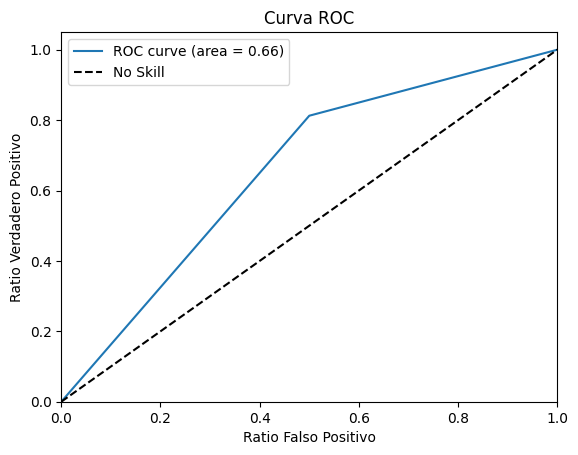

In [13]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falso Positivo')
plt.ylabel('Ratio Verdadero Positivo')
plt.title('Curva ROC')
plt.legend()
plt.show()